In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.basemap import Basemap # plot on map projections
import netCDF4 as nc
import IPython.display
import cmocean
from glob import glob
import os,sys
import yaml
import math
import xarray as xr
import copy

sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
data = copy.deepcopy(exptdata.exptdict)  # to store fields under the same keys as exptdata.exptdict

# inputs used for final runs, copied from /short/public
data['1deg']['mominput'] = 'access-om2/input_236a3011/mom_1deg'
data['025deg']['mominput'] = 'access-om2/input_236a3011/mom_025deg'
data['01deg']['mominput'] = 'access-om2/input_38570c62/mom_01deg'

In [23]:
for ekey in data.keys():
    e = data[ekey]
    outdirs = glob(os.path.join(e['exptdir'], 'output*'))
    outdirs.sort()
    e['lastout'] = outdirs[-1]    
    e['st_edges_ocean'] = xr.open_dataset(e['lastout']+'/ocean/ocean.nc').st_edges_ocean#.values
    e['kmt'] = xr.open_dataset(e['lastout']+'/ocean/ocean_grid.nc').kmt #.values
    e['depth'] = xr.open_dataset(e['mominput']+'/topog.nc').depth  # partial depth
    kmt_idx = e['kmt'].astype(np.int64).clip(min=0)
    tmp = e['st_edges_ocean'][kmt_idx]  # full depth, land is zero
    e['depth_full'] = tmp.where(tmp > 0)  # full depth, land is nan
    dzfull = e['st_edges_ocean'].diff('st_edges_ocean')
    dzftmp = dzfull[e['kmt'].astype(np.int64).clip(min=1)-1]  # full depth dz, land is wrong
    e['dz_full'] = dzftmp.where(tmp > 0)  # full depth dz, land is nan
    dztmp = e['depth'].values - e['st_edges_ocean'][(kmt_idx-1).clip(min=0)]  # partial depth dz, land is wrong
    e['dz'] = dztmp.where(tmp > 0)  # partial depth dz, land is nan

In [24]:
for ekey in data.keys():
    e = data[ekey]
    print(ekey, e['desc'])
    print('min levels =', int(e['kmt'].min().item(0)))
    print('min partial cell depth   =', e['depth'].where(e['depth']>0).min().item(0),'m')
#     print('min full cell depth =', e['st_edges_ocean'][int(e['kmt'].min().item(0))].item(0),'m')
    print('min full cell depth =', e['depth_full'].min().item(0),'m')
    print('min partial cell thickness at bottom =', e['dz'].min().item(0),'m')
    print('min full cell thickness at bottom =', e['dz_full'].min().item(0),'m')
    print()

1deg ACCESS-OM2
min levels = 10
min partial cell depth   = 45.111485611302065 m
min full cell depth = 51.04873935697576 m
min partial cell thickness at bottom = 2.9616320801266482 m
min full cell thickness at bottom = 9.308074817051192 m

025deg ACCESS-OM2-025
min levels = 9
min partial cell depth   = 40.355926513671875 m
min full cell depth = 41.740664539924566 m
min partial cell thickness at bottom = 3.4559898943524416 m
min full cell thickness at bottom = 7.971549214042142 m

01deg ACCESS-OM2-01
min levels = 7
min partial cell depth   = 10.432805061340332 m
min full cell depth = 10.432805425955316 m
min partial cell thickness at bottom = 1.9718405679982212 m
min full cell thickness at bottom = 1.9718409326132047 m



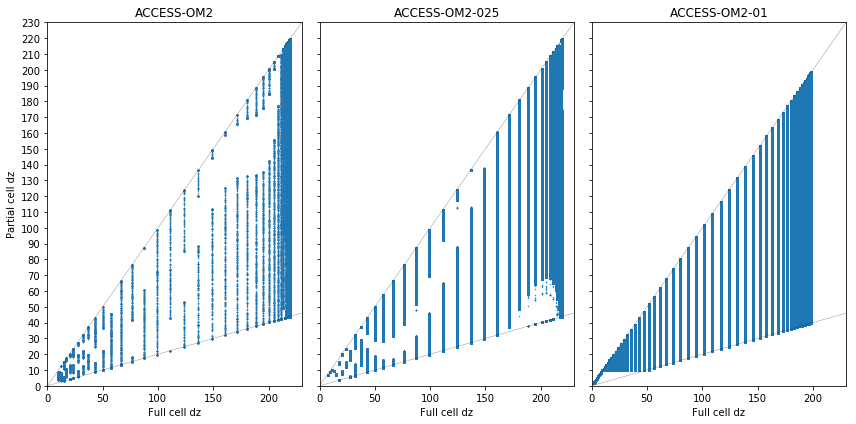

In [25]:
plt.figure(figsize=(12,6))
for i, ekey in enumerate(data.keys()):
    e = data[ekey]
    plt.subplot(1,3,i+1)
    plt.plot([0, 230],[0,230],'k',linewidth=0.2)
    plt.plot([0, 230],[0,230*0.2],'k',linewidth=0.2)
    plt.scatter(e['dz_full'], e['dz'], s=0.2)
    plt.xlim(0,230)
    plt.ylim(0,230)
    plt.yticks(np.arange(0, 231, step=10))
    plt.xlabel('Full cell dz')
    plt.title(e['desc'])
    if i == 0:
        plt.ylabel('Partial cell dz')
    else:
        plt.gca().axes.yaxis.set_ticklabels([])
plt.tight_layout()
savefigure('partialcells.png')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


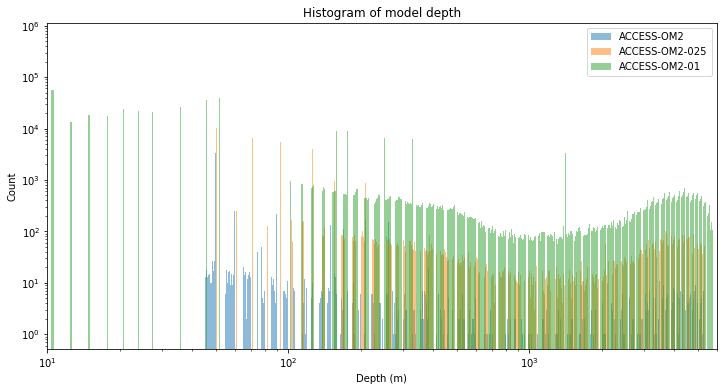

In [13]:
plt.figure(figsize=(12,6))
for ekey in data.keys():
    e = data[ekey]
    plt.hist(np.ma.ravel(e['depth']), bins=20000, alpha=0.5, log=True, label=e['desc'])
plt.xlim(10,6000)
plt.xscale('log')
plt.xlabel('Depth (m)')
plt.ylabel('Count');
plt.title('Histogram of model depth');
plt.legend(loc='upper right')

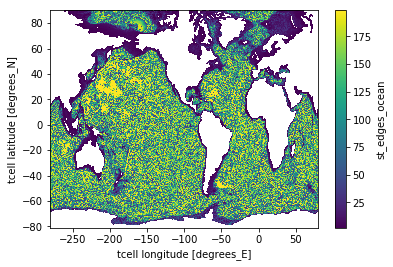

In [14]:
e['dz'].plot()

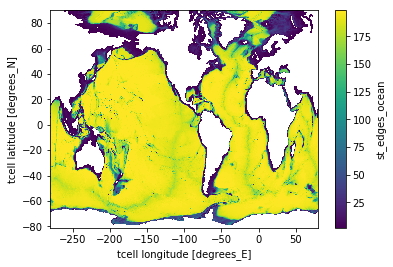

In [132]:
e['dz_full'].plot()

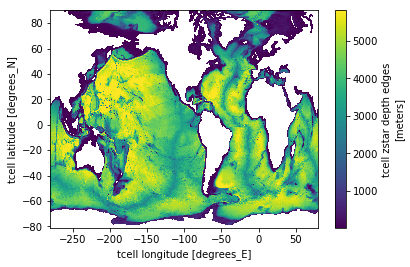

In [113]:
e['depth_full'].plot()

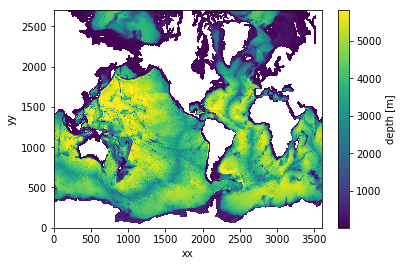

In [107]:
e['depth'].plot()